In [35]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from PIL import Image
import random
import seaborn as sns

In [36]:
data_dir = Path(os.getcwd()) / "DATASET"
test_dir = data_dir / "test"
train_dir = data_dir / "train"
val_dir = data_dir / "val"

print(f"Train Directory : {train_dir}")
print(f"Validation Directory : {val_dir}")
print(f"Test Directory : {test_dir}")

Train Directory : d:\Project\Pancreatic-tumor\DATASET\train
Validation Directory : d:\Project\Pancreatic-tumor\DATASET\val
Test Directory : d:\Project\Pancreatic-tumor\DATASET\test


In [37]:
total_class_train = len(os.listdir(train_dir))
total_class_val = len(os.listdir(val_dir))
total_test = len(os.listdir(test_dir))

print(f"Total of Train Data Classes: {total_class_train} classes")
print(f"Total of Validation Data Classes: {total_class_val} classes")
print(f"Total of Test Data: {total_test} images")

Total of Train Data Classes: 2 classes
Total of Validation Data Classes: 2 classes
Total of Test Data: 48 images


In [38]:
def data_per_class(path):
    data=sorted(os.listdir(path))
    class_count = {}
    for cls in data:
        class_dir = os.path.join(path,cls)
        class_count[cls] = len(os.listdir(class_dir))
    return class_count

train_class_counts = data_per_class(train_dir)
val_class_counts = data_per_class(val_dir)

train_counts_df = pd.DataFrame.from_dict(train_class_counts, orient="index", columns=["Count"])
val_counts_df = pd.DataFrame.from_dict(val_class_counts, orient="index", columns=["Count"])

In [39]:
train_counts_df

,Count
normal,421
pancreatic_tumor,578


In [40]:
val_counts_df

,Count
normal,225
pancreatic_tumor,187


In [41]:
def resize_images(dir):
    width = 112
    height = 112
    image_dir = sorted(os.listdir(dir))
    for img in image_dir:
        image_path = os.path.join(dir, img)
        if image_path.endswith(('.png', '.jpg')):
            image = Image.open(image_path)
            resized_img = image.resize((width, height))
            resized_img.save(image_path)
        else:
            for i in os.listdir(image_path):
                i = os.path.join(image_path,i)
                image = Image.open(i)
                resized_img = image.resize((width, height))
                resized_img.save(i)
    print("Resizing Completed!!")

In [42]:
# resize_images(train_dir)
# resize_images(test_dir)
# resize_images(val_dir)

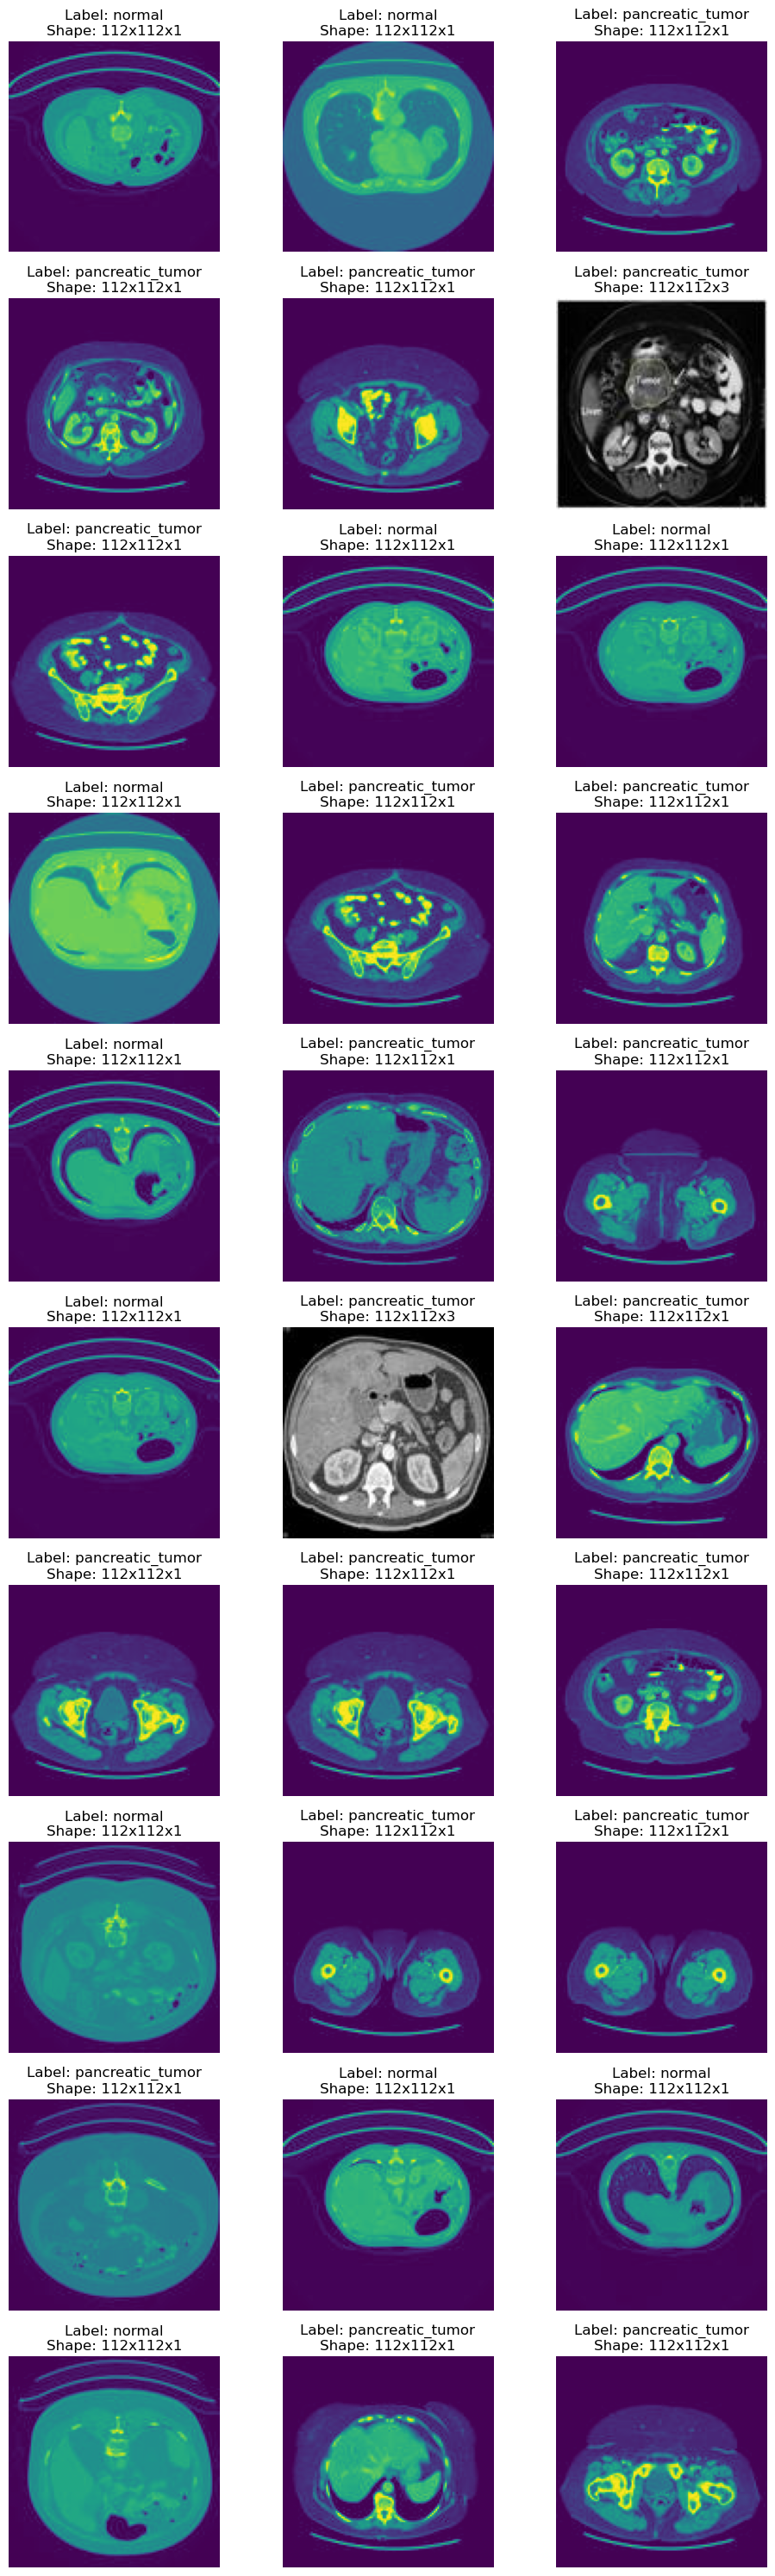

In [43]:
random.seed(33)
image_path_list = list(data_dir.glob("*/*/*.jpg"))
random_image_paths = random.sample(image_path_list, 30)
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 30))
for i, ax in enumerate(axes.flat):
    random_image_path = random_image_paths[i]
    image_class = random_image_path.parent.stem
    image = Image.open(random_image_path)
    ax.imshow(image)
    ax.set_title(f"Label: {image_class}\nShape: {image.height}x{image.width}x{3 if image.mode == 'RGB' else 1}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [44]:
class_names = [i for i in os.listdir(train_dir)]
class_names

['normal', 'pancreatic_tumor']

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


img_height = 112
img_width = 112
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

model = models.Sequential([
            layers.Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(112,112,3)),
            layers.MaxPooling2D((2,2),strides=2),
            layers.Conv2D(64,(3,3),padding='same',activation='relu'),
            layers.MaxPooling2D((2,2),strides=2),
            layers.Conv2D(128,(3,3),padding='same',activation='relu'),
            layers.MaxPooling2D((2,2),strides=2),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(1, activation='sigmoid')
        ])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.FalseNegatives(),
    ],
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping]
)

Found 999 images belonging to 2 classes.
Found 412 images belonging to 2 classes.


d:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 438ms/step - binary_accuracy: 0.7914 - false_negatives_1: 46.5152 - loss: 0.4533 - val_binary_accuracy: 1.0000 - val_false_negatives_1: 0.0000e+00 - val_loss: 2.3175e-05 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - binary_accuracy: 0.9558 - false_negatives_1: 17.6970 - loss: 0.1654 - val_binary_accuracy: 1.0000 - val_false_negatives_1: 0.0000e+00 - val_loss: 6.9151e-05 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 366ms/step - binary_accuracy: 0.9747 - false_negatives_1: 12.2424 - loss: 0.1151 - val_binary_accuracy: 1.0000 - val_false_negatives_1: 0.0000e+00 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 359ms/step - binary_accuracy: 0.9762 - false_negatives_1: 12.7273 - loss: 0.0982 - val_binary_accuracy: 1.0000 - val_false_negatives_1: 0.0000e+00 - val_loss: 5.4264e-04 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 427ms/step - binar

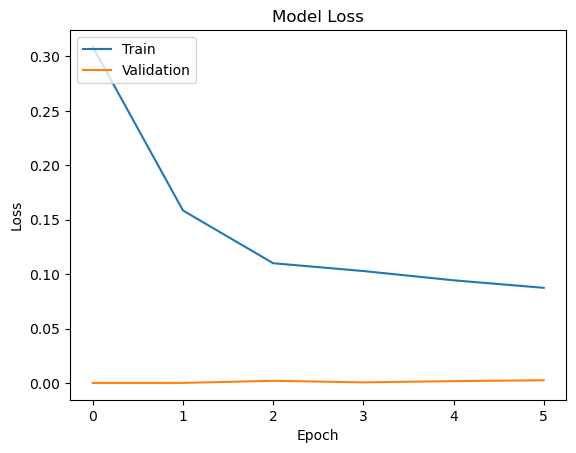

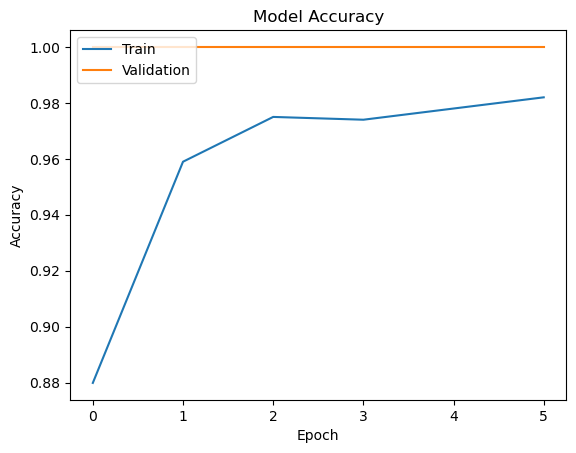

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [47]:
val_loss, val_accuracy, false_negatives = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"False Negatives: {false_negatives}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - binary_accuracy: 1.0000 - false_negatives_1: 0.0000e+00 - loss: 0.0027
Validation Loss: 0.0024849071633070707
Validation Accuracy: 1.0
False Negatives: 0.0


In [48]:
# model.save('model.h5')

In [49]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    prediction = model.predict(img_array)
    return prediction

img_path = 'D:/Project/Pancreatic-tumor/DATASET/train/pancreatic_tumor/1-174.jpg'
prediction = predict_image(img_path)
print(f"Prediction: {class_names[int(prediction[0][0])]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Prediction: pancreatic_tumor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_3888\2649898391.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Pred: {class_names[int(predictions[i])]}\nTrue: {class_names[int(test_labels[i])]}")


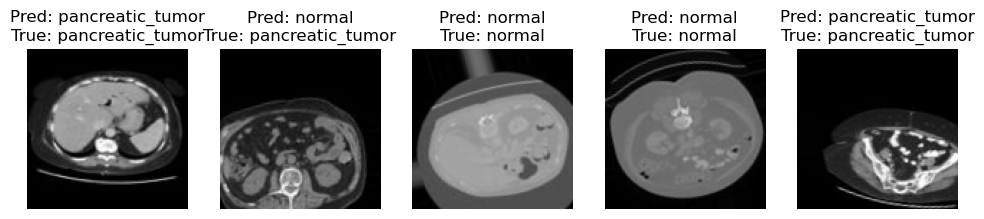

In [50]:
import matplotlib.pyplot as plt

def plot_predictions(test_generator, num_images=5):
    test_images, test_labels = next(test_generator)
    predictions = model.predict(test_images)

    plt.figure(figsize=(12, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[i])
        plt.title(f"Pred: {class_names[int(predictions[i])]}\nTrue: {class_names[int(test_labels[i])]}")
        plt.axis('off')
    plt.show()

plot_predictions(train_generator)

In [55]:
import matplotlib.pyplot as plt
from sklearn import metrics

test_images,actual = next(train_generator)
pred = model.predict(test_images)
predicted = [int(p) for p in pred]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_3888\482496132.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted = [int(p) for p in pred]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


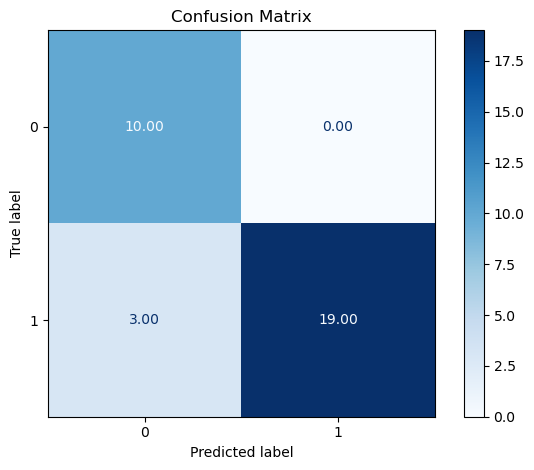

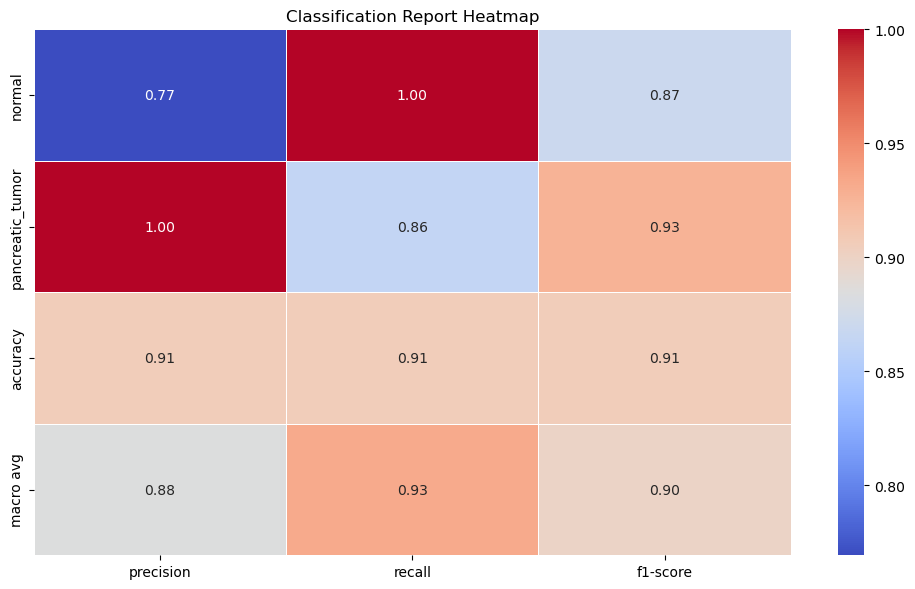

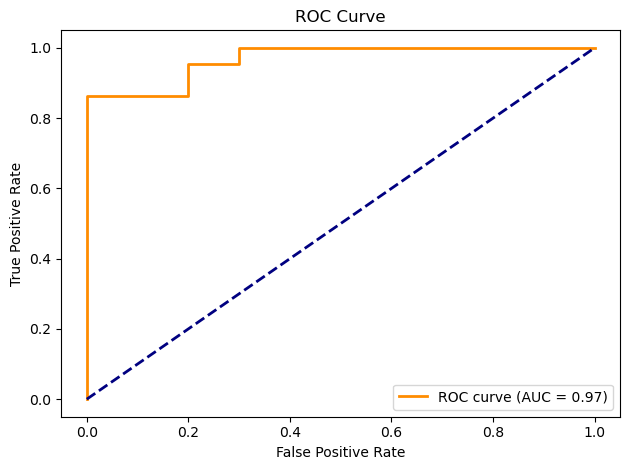

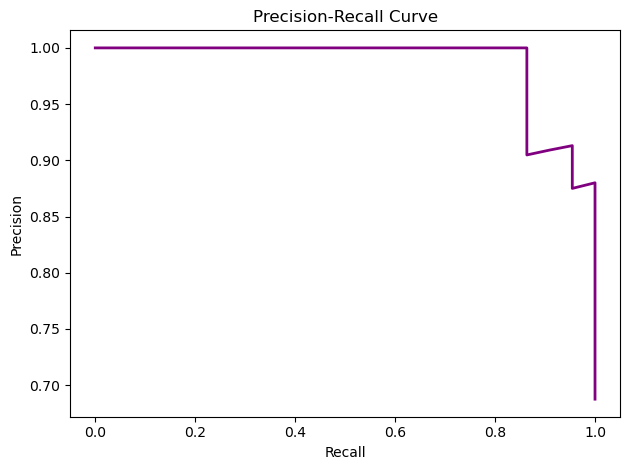

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)

# Generate a batch of images and true labels
imgs, y_true = next(train_generator)

# Get predictions from the model
y_pred_probs = model.predict(imgs)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification Report Heatmap
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Classification Report Heatmap")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.figure()
plt.plot(recall, precision, color="purple", lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.show()